In [17]:
# Import required modules
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [18]:
# Set plot params
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [20, 9]
plt.rcParams['lines.linewidth'] = 1

In [19]:
df = pd.read_csv("data/processed_dataset/dataset_p1.csv")
df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume,Sentiment Score
Date,,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300,0.4134
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100,0.4134
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800,0.4134
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800,0.4134
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900,0.4134


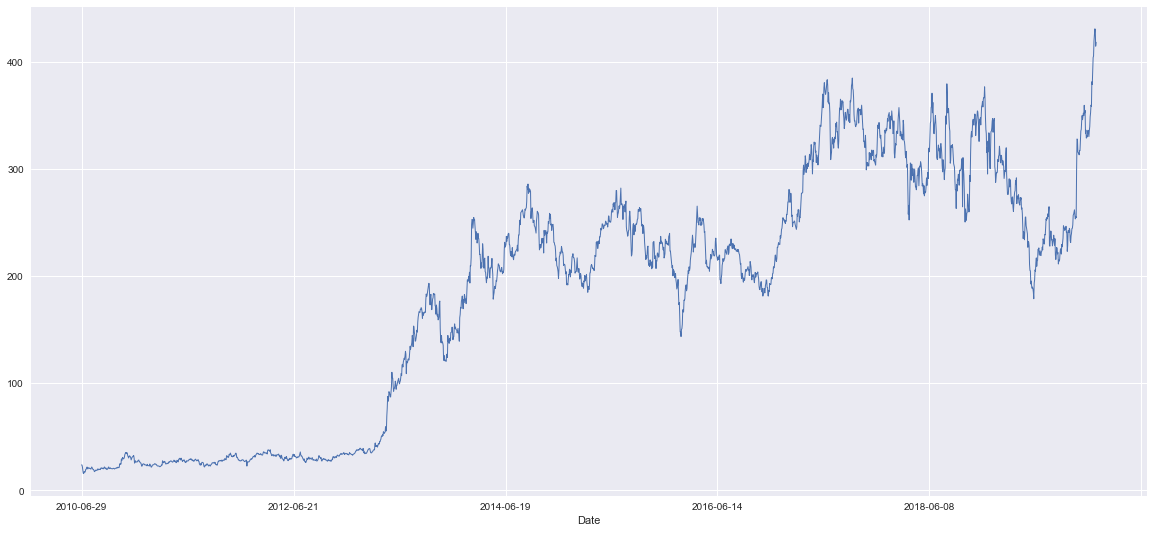

In [20]:
# Plot of the close price of TSLA
df['Close'].plot()
plt.show()

In [21]:
def get_rsi(df):
    '''
    Compute the relative strength index of the stock.
    Relative Strength Index (RSI) - https://www.investopedia.com/terms/r/rsi.asp
    '''
    diff = df.Close.diff().dropna()
    plus = diff.map(lambda x: x if x > 0 else 0).rename('Plus')
    minus = diff.map(lambda x: -1*x if x < 0 else 0).rename('Minus')

    temp = pd.concat([diff , plus, minus], axis = 1)
    temp['AvgUP'] = temp.Plus[:14].sum() / 14
    temp['AvgDOWN'] = temp.Minus[:14].sum() / 14

    for i in range(14, temp.Close.size):
        temp['AvgUP'].iloc[i] = (temp['Plus'].iloc[i] + 13*temp['AvgUP'].iloc[i-1]) / 14
        temp['AvgDOWN'].iloc[i] = (temp['Minus'].iloc[i] + 13*temp['AvgDOWN'].iloc[i-1]) / 14

    temp['RSI'] = 100 - (100 / (1 + temp['AvgUP'] / temp['AvgDOWN']))
    
    return [np.nan] + temp['RSI'].tolist()


In [22]:
def get_macd(df, short, long):
    '''
    Compute MACD of the stock.
    Moving Average Convergence Divergence (MACD) - https://www.investopedia.com/terms/m/macd.asp
    '''
    ema_short = df.Close.ewm(span=short, adjust=False).mean()
    ema_long = df.Close.ewm(span=long, adjust=False).mean()
    macd_line = ema_short - ema_long
    
    return macd_line.tolist()

In [23]:
def get_log_return(df):
    '''
    Compute log return on the stock.
    '''
    return np.log(df['Close']).shift(-1) - np.log(df['Close']) # Calculate log return

In [24]:
def get_intermediate_momentum(df, period):
    '''
    Compute momentum of the stock.
    '''
    return df.Close.diff(period)

In [25]:
def prepare_dataset(df, short, long, period):
    '''
    Prepare dataset with feature engineered columns.
    '''
    df['LogReturn'] = get_log_return(df) # Get the return of the stock
    df['RSI14'] = get_rsi(df) # Get a short term indicator
    df['MACD'] = get_macd(df, short,long) # Get a long term indicator
    df['Intermediate Momentum'] = get_intermediate_momentum(df, period) # Get a internmediate term indicator
    
    df.dropna(inplace = True)
    
    return df

In [26]:
# Define timeframes for indicators
short_term_timeframe = 20 # short term period
long_term_timeframe = 200 # long term period
intermediate_term_timeframe = 60 # intermediate term period

In [27]:
df = prepare_dataset(df, short_term_timeframe, long_term_timeframe, intermediate_term_timeframe)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Sentiment Score,LogReturn,RSI14,MACD,Intermediate Momentum
Date,,,,,,,,,,,
2010-09-23,19.889999,20.139999,19.500000,19.559999,19.559999,668100,0.4134,0.027233,44.122541,-1.735004,-4.330000
2010-09-24,19.950001,20.190001,19.650000,20.100000,20.100000,578900,0.4134,0.021167,47.909296,-1.742300,-3.730000
2010-09-27,20.400000,20.809999,20.049999,20.530001,20.530001,418600,0.4134,0.041504,50.770293,-1.710510,-1.429998
2010-09-28,21.040001,21.490000,20.760000,21.400000,21.400000,1214500,0.4134,0.026742,56.032012,-1.606212,2.199999
2010-09-29,21.190001,22.030001,21.129999,21.980000,21.980000,1969300,0.4134,-0.074108,59.165457,-1.461798,5.869999


In [13]:
# File path

save_path = 'data/processed_dataset/dataset_p2.csv'

In [28]:
# Write to csv

df.to_csv(save_path, encoding='utf-8', index=False)

### Plotting Data

In [29]:
def normalize(df):
    '''
    Normalize dataset.
    '''
    df.dropna(inplace = True)
    cols = df.columns.tolist()
    for c in cols:
        df[c] = MinMaxScaler().fit_transform(np.array(df[c]).reshape(-1,1))

    return df

  

In [30]:
normalized_df = normalize(df)

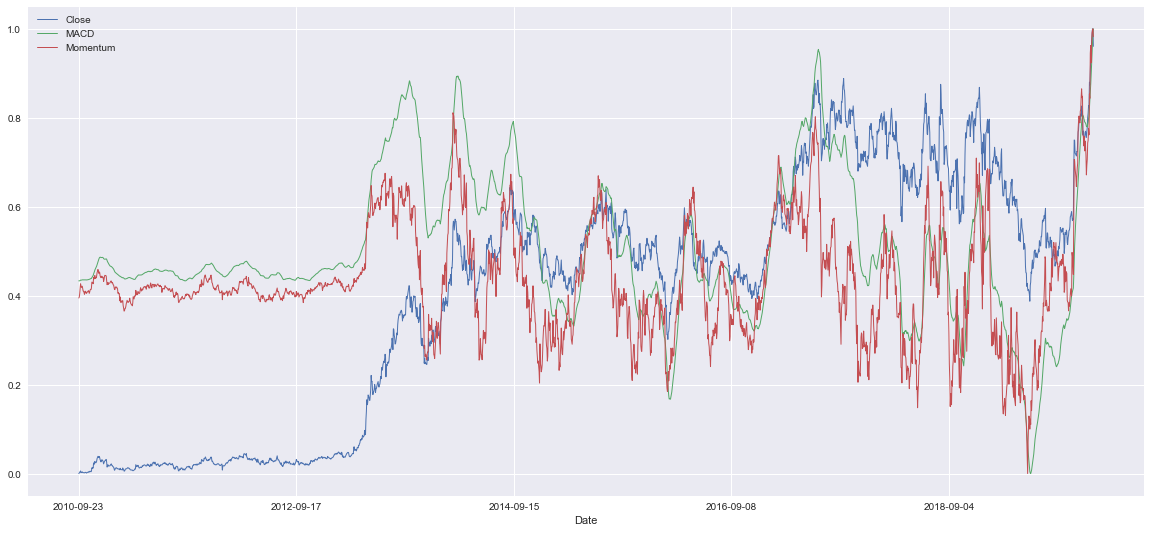

In [42]:
normalized_df['Close'].plot(label='Close')
normalized_df['MACD'].plot(label='MACD')
normalized_df['Intermediate Momentum'].plot(label='Momentum')
plt.legend()
plt.show()

As we can see in the above plot, the long and intermediate term indicators are follow a similar trend compared to the close price of the stock. The y-intercept of the indicators are far higher than that of the close price, as expected, since the indicators consider a longer time window in which the TSLA stock does exceptionally well.

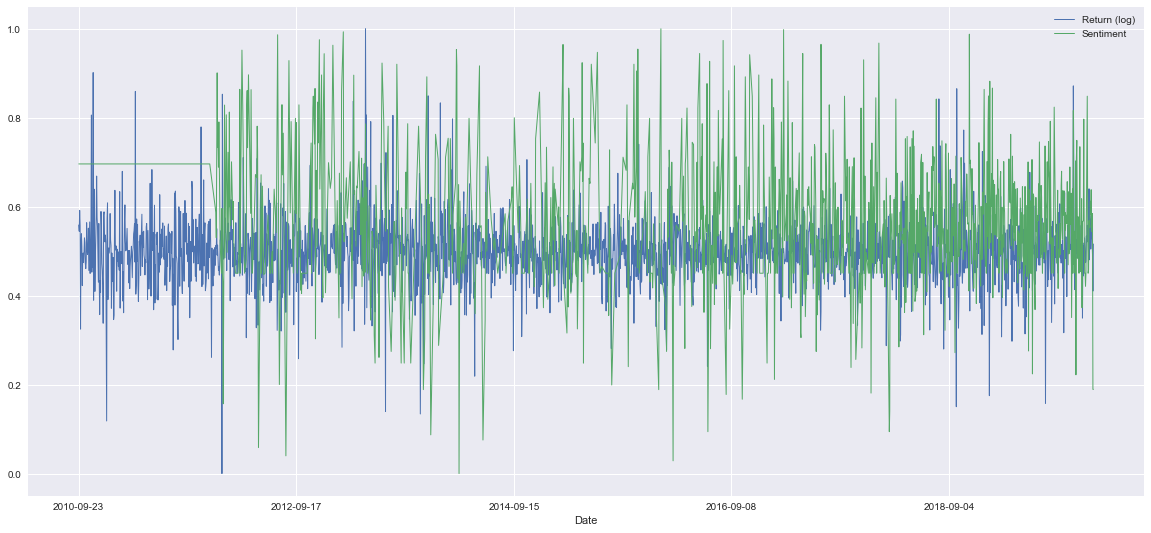

In [49]:
normalized_df['LogReturn'].plot(label='Return (log)')
normalized_df['Sentiment Score'].plot(label='Sentiment')
plt.legend()
plt.show()

It is difficult to notice a trend between the return of TSLA stock and the sentiment. I am hoping to see its helpfulness in the latent space.

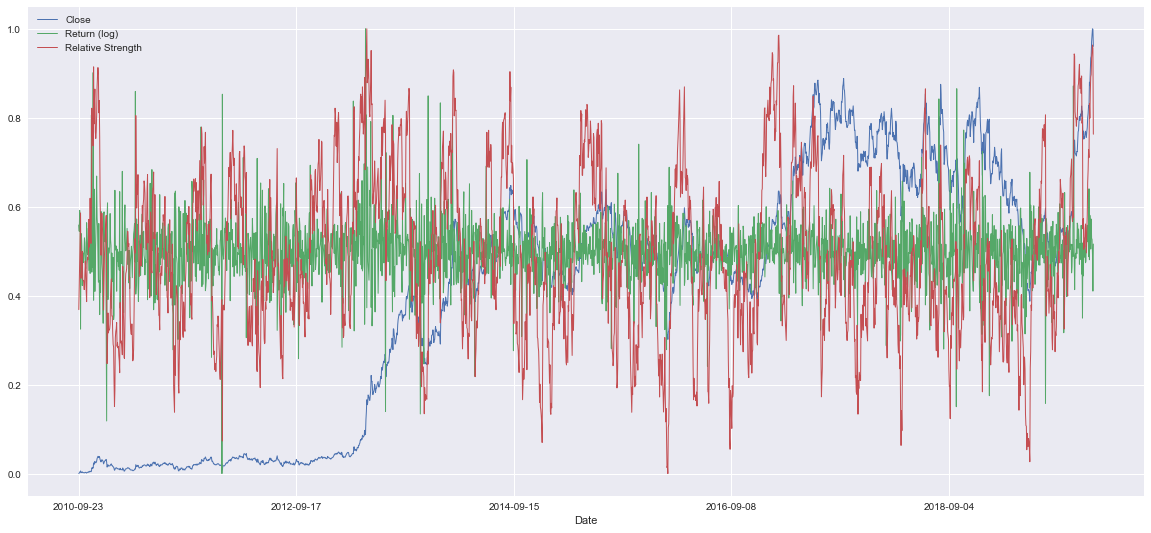

In [50]:
normalized_df['Close'].plot(label='Close')
normalized_df['LogReturn'].plot(label='Return (log)')
normalized_df['RSI14'].plot(label='Relative Strength')
plt.legend()
plt.show()

The short term indicator (rsi) does provide some insights into the trend of the close price of TSLA stock, however, due to its short term nature, this is restricted to far smaller windows. In addition, we are able to see a correspondence between the return and the rsi. I am hoping that this will provide short term knowledge of the stock to my model.